<a href="https://colab.research.google.com/github/chefdarek/DS-Unit-2-Regression-2/blob/master/module2-gradient-boosting/Gradient_Boosting_Caterpillar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

In [2]:
!unzip caterpillar-tube-pricing.zip

Archive:  caterpillar-tube-pricing.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.csv   
  inflating: data.zip                


In [3]:
!unzip data.zip

Archive:  data.zip
replace competition_data/bill_of_materials.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: competition_data/bill_of_materials.csv  
  inflating: competition_data/comp_adaptor.csv  
  inflating: competition_data/comp_boss.csv  
  inflating: competition_data/comp_elbow.csv  
  inflating: competition_data/comp_float.csv  
  inflating: competition_data/comp_hfl.csv  
  inflating: competition_data/comp_nut.csv  
  inflating: competition_data/comp_other.csv  
  inflating: competition_data/comp_sleeve.csv  
  inflating: competition_data/comp_straight.csv  
  inflating: competition_data/comp_tee.csv  
  inflating: competition_data/comp_threaded.csv  
  inflating: competition_data/components.csv  
  inflating: competition_data/specs.csv  
  inflating: competition_data/test_set.csv  
  inflating: competition_data/train_set.csv  
  inflating: competition_data/tube.csv  
  inflating: competition_data/tube_end_form.csv  
  inflating: competition_data/type_component.csv 

Makes a data dictionary of files to call by filename

In [ ]:
import pandas as pd
from glob import glob
import re

data = {}
for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    folder, filename = path.split('/')
    name, extension = filename.split('.')
    data[name] = df

Call via

In [5]:
data['test_set'].head()

,id,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity
0,1,TA-00001,S-0066,2013-06-23,0,0,Yes,1
1,2,TA-00001,S-0066,2013-06-23,0,0,Yes,2
2,3,TA-00001,S-0066,2013-06-23,0,0,Yes,5
3,4,TA-00001,S-0066,2013-06-23,0,0,Yes,10
4,5,TA-00001,S-0066,2013-06-23,0,0,Yes,25


In [6]:
data['specs'].head()


,tube_assembly_id,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10
0,TA-00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
!pip install category_encoders

In [ ]:
import category_encoders as ce
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
#Learns sequestially and slowly, more trees than default could be better
#Default is 100
from xgboost import XGBRegressor

In [17]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

#ONLY NEED RMSLE WHEN THE y_true and y_predict are not already log'd

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge tube data
    tube = pd.read_csv('competition_data/tube.csv')
    X = X.merge(tube, how='left')
    
    # Engineer features from bill_of_materials
    materials = pd.read_csv('competition_data/bill_of_materials.csv')
    
    materials['components_total'] = (materials['quantity_1'].fillna(0) + 
                                     materials['quantity_2'].fillna(0) + 
                                     materials['quantity_3'].fillna(0) + 
                                     materials['quantity_4'].fillna(0) + 
                                     materials['quantity_5'].fillna(0) + 
                                     materials['quantity_6'].fillna(0) + 
                                     materials['quantity_7'].fillna(0) + 
                                     materials['quantity_8'].fillna(0))

    materials['components_distinct'] = (materials['component_id_1'].notnull().astype(int) + 
                                        materials['component_id_2'].notnull().astype(int) + 
                                        materials['component_id_3'].notnull().astype(int) + 
                                        materials['component_id_4'].notnull().astype(int) + 
                                        materials['component_id_5'].notnull().astype(int) + 
                                        materials['component_id_6'].notnull().astype(int) + 
                                        materials['component_id_7'].notnull().astype(int) + 
                                        materials['component_id_8'].notnull().astype(int))
    
    
    # Merge selected features from bill_of_materials
    #MERGING ALL FROM BILL_OF_MATErIALs
    features = ['tube_assembly_id', 'component_id_1', 'components_total', 'components_distinct']
    X = X.merge(materials, how='left')
    
    # Get component_type_id (has lower cardinality than component_id)
    #components = pd.read_csv('competition_data/components.csv')
    #components = components.rename(columns={'component_id': 'component_id_1'})
    #features = ['component_id_1', 'component_type_id']
    #X = X.merge(components, how='left')
    
    # Count the number of specs for the tube assembly
    specs = pd.read_csv('competition_data/specs.csv')
    specs['specs_total'] = specs.drop(columns=['tube_assembly_id']).count(axis=1)
    features = ['tube_assembly_id', 'specs_total', 'spec1', 'spec2']
    X = X.merge(specs[features], how='left')
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    

    
    return X


  
# Read data
trainval = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

# Split into train & validation sets
# All rows for a given tube_assembly_id should go in either train or validation
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

# Wrangle train, validation, and test sets
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)
#Drop Rows with all NaNs for subset of added features


# Arrange X matrix and y vector (log-transformed)
target = 'cost'
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns='id')
y_train = train[target]
y_val = val[target]
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='constant', fill_value=0), 
    RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1)
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

Validation Error 0.29252335295170445


In [10]:
train.head()

,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,quote_date_year,quote_date_month,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8,components_total,components_distinct,name,component_type_id,specs_total,spec1,spec2
8,S-0066,0,0,Yes,1,28.374220,2013,9,SP-0029,19.05,1.24,109.0,4,50.8,N,N,N,N,EF-003,EF-003,0,0,0,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3,NUT-SWIVEL,CP-025,0,NaN,NaN
9,S-0066,0,0,Yes,2,16.514303,2013,9,SP-0029,19.05,1.24,109.0,4,50.8,N,N,N,N,EF-003,EF-003,0,0,0,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3,NUT-SWIVEL,CP-025,0,NaN,NaN
10,S-0066,0,0,Yes,5,9.397795,2013,9,SP-0029,19.05,1.24,109.0,4,50.8,N,N,N,N,EF-003,EF-003,0,0,0,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3,NUT-SWIVEL,CP-025,0,NaN,NaN
11,S-0066,0,0,Yes,10,7.027481,2013,9,SP-0029,19.05,1.24,109.0,4,50.8,N,N,N,N,EF-003,EF-003,0,0,0,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3,NUT-SWIVEL,CP-025,0,NaN,NaN
12,S-0066,0,0,Yes,25,5.603067,2013,9,SP-0029,19.05,1.24,109.0,4,50.8,N,N,N,N,EF-003,EF-003,0,0,0,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3,NUT-SWIVEL,CP-025,0,NaN,NaN


In [11]:
X_train.head()

,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,quote_date_year,quote_date_month,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8,components_total,components_distinct,name,component_type_id,specs_total,spec1,spec2
8,S-0066,0,0,Yes,1,2013,9,SP-0029,19.05,1.24,109.0,4,50.8,N,N,N,N,EF-003,EF-003,0,0,0,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3,NUT-SWIVEL,CP-025,0,NaN,NaN
9,S-0066,0,0,Yes,2,2013,9,SP-0029,19.05,1.24,109.0,4,50.8,N,N,N,N,EF-003,EF-003,0,0,0,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3,NUT-SWIVEL,CP-025,0,NaN,NaN
10,S-0066,0,0,Yes,5,2013,9,SP-0029,19.05,1.24,109.0,4,50.8,N,N,N,N,EF-003,EF-003,0,0,0,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3,NUT-SWIVEL,CP-025,0,NaN,NaN
11,S-0066,0,0,Yes,10,2013,9,SP-0029,19.05,1.24,109.0,4,50.8,N,N,N,N,EF-003,EF-003,0,0,0,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3,NUT-SWIVEL,CP-025,0,NaN,NaN
12,S-0066,0,0,Yes,25,2013,9,SP-0029,19.05,1.24,109.0,4,50.8,N,N,N,N,EF-003,EF-003,0,0,0,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3,NUT-SWIVEL,CP-025,0,NaN,NaN


Predicts on the augmented test df and then refactors back to $$ 
Then subs the pred value of cost onto the df and creates a file
needs estimator name i.e. 'pipline" in this case'

In [ ]:
test_set = pd.read_csv('competition_data/test_set.csv')
test_set.shape
test_set = pd.DataFrame(test_set.id)

In [ ]:
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)
submission = test_set.copy()
submission['cost'] = y_pred
submission.to_csv('DareksubmissionCatepillar-05.csv', index=False)

In [ ]:

def generate_submission(estimator, X_test, filename):
    y_pred_log = estimator.predict(X_test)
    y_pred = np.expm1(y_pred_log)  # Convert from log-dollars to dollars
    submission = pd.read_csv('sample_submission.csv')
    submission['cost'] = y_pred
    submission.to_csv(filename, index=False)
    
generate_submission(pipeline, X_test, 'submission-0gen.csv')

In [ ]:
plt.figure(figsize=(10,10))
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='grey');

XGBoost: makes shallow trees, but sequentially, then makes new trees of the errors (residuals) see
https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

Early Stoppage For Xboost to stop overfitting with early_stopping_rounds

early_stopping_rounds (int, optional) – Activates early stopping. Validation error needs to decrease at least every <early_stopping_rounds> round(s) to continue training. Requires at least one item in evals. If there’s more than one, will use the last. If early stopping occurs, the model will have three additional fields: bst.best_score, bst.best_iteration and bst.best_ntree_limit (bst.best_ntree_limit is the ntree_limit parameter default value in predict method if not any other value is specified). (Use bst.best_ntree_limit to get the correct value if num_parallel_tree and/or num_class appears in the parameters

for use with pipeline

In [ ]:
#class XGRegressorEval(XGBRegressor):
 # def fit(self, *args, **kwargs):
   # return super().fit(*args, eval_set=eval_set, eval_metric='rmse', 
         # early_stopping_rounds=10, **kwargs)
    
#pipeline = make_pipeline(ce.OrdinalEncoder(), XGRegressorEval(n_estimators=1000, n_jobs=-1))

In [ ]:
import category_encoders as ce
from xgboost import XGBRegressor
encoder = ce.OrdinalEncoder()
#learn the fit
X_train_encoded = encoder.fit_transform(X_train)
#apply the fit to the X_val set for congruency
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

In [ ]:
#have to pass the params on the fit
#model = XGBRegressor()
#model.fit(X_train_encoded, y_train_log, eval_set=..., eval_metric=..., 
          #early_stopping_rounds=...)

In [19]:

eval_set = [(X_train_encoded, y_train_log), 
            (X_val_encoded, y_val_log)]

#upto 1000 splits but after 10 if the rmse is not improved it will early stop 
#with this param setup
model = XGBRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train_encoded, y_train_log, eval_set=eval_set, eval_metric='rmse', 
          early_stopping_rounds=10)

[21:54:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.71915	validation_1-rmse:1.70772
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.56488	validation_1-rmse:1.55406


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[2]	validation_0-rmse:1.42747	validation_1-rmse:1.41688
[3]	validation_0-rmse:1.30301	validation_1-rmse:1.29247
[4]	validation_0-rmse:1.19115	validation_1-rmse:1.18159
[5]	validation_0-rmse:1.09288	validation_1-rmse:1.08363
[6]	validation_0-rmse:1.00652	validation_1-rmse:1.0004
[7]	validation_0-rmse:0.927824	validation_1-rmse:0.922708
[8]	validation_0-rmse:0.859384	validation_1-rmse:0.854549
[9]	validation_0-rmse:0.797892	validation_1-rmse:0.793536
[10]	validation_0-rmse:0.745127	validation_1-rmse:0.743214
[11]	validation_0-rmse:0.699104	validation_1-rmse:0.698741
[12]	validation_0-rmse:0.657494	validation_1-rmse:0.657461
[13]	validation_0-rmse:0.621634	validation_1-rmse:0.622084
[14]	validation_0-rmse:0.590776	validation_1-rmse:0.59252
[15]	validation_0-rmse:0.561993	validation_1-rmse:0.564018
[16]	validation_0-rmse:0.53785	validation_1-rmse:0.540935
[17]	validation_0-rmse:0.517702	validation_1-rmse:0.521339
[18]	validation_0-rmse:0.498756	validation_1-rmse:0.504111
[19]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [23]:
X_test.head()

,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,quote_date_year,quote_date_month,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8,components_total,components_distinct,name,component_type_id,specs_total,spec1,spec2
0,S-0066,0,0,Yes,1,2013,6,SP-0035,12.7,1.65,164.0,5,38.1,N,N,N,N,EF-003,EF-003,0,0,0,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2,NUT-SWIVEL,CP-025,0,NaN,NaN
1,S-0066,0,0,Yes,2,2013,6,SP-0035,12.7,1.65,164.0,5,38.1,N,N,N,N,EF-003,EF-003,0,0,0,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2,NUT-SWIVEL,CP-025,0,NaN,NaN
2,S-0066,0,0,Yes,5,2013,6,SP-0035,12.7,1.65,164.0,5,38.1,N,N,N,N,EF-003,EF-003,0,0,0,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2,NUT-SWIVEL,CP-025,0,NaN,NaN
3,S-0066,0,0,Yes,10,2013,6,SP-0035,12.7,1.65,164.0,5,38.1,N,N,N,N,EF-003,EF-003,0,0,0,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2,NUT-SWIVEL,CP-025,0,NaN,NaN
4,S-0066,0,0,Yes,25,2013,6,SP-0035,12.7,1.65,164.0,5,38.1,N,N,N,N,EF-003,EF-003,0,0,0,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2,NUT-SWIVEL,CP-025,0,NaN,NaN


In [ ]:
test_set = pd.read_csv('competition_data/test_set.csv')
test_set.shape
test_set = pd.DataFrame(test_set.id)

In [ ]:
y_pred_log = model.predict(X_test_encoded)

In [36]:
y_pred_log.shape

(30235,)

In [32]:
test_set.shape

(30235, 1)

In [ ]:

y_pred = np.expm1(y_pred_log)
submission = test_set.copy()
submission['cost'] = y_pred
submission.to_csv('DareksubmissionCatepillar-05.csv', index=False)

left validation_0-rmse:0.whaterver is the first passed in eval set so the train
right "                                                " is the val/test set depending on what was passed

*Visualize the learning rate and difference in val and train*

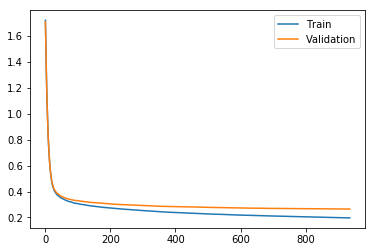

In [38]:
results = model.evals_result()
train_rmse = results['validation_0']['rmse']
val_rmse = results['validation_1']['rmse']
epoch = range(len(train_rmse))
plt.plot(epoch, train_rmse, label='Train')
plt.plot(epoch, val_rmse, label='Validation')
plt.legend();

Another Submission file from the Xgboost model

In [ ]:
X_test_encoded = encoder.transform(X_test)
generate_submission(model, X_test_encoded, 'submission-04.csv')

Assuming you've set up a GPU correctly locally or are using Colab and have set the runtime to use a GPU you can add these parameters to XGB and speed up your training by almost 10x
```gpu_id=0, tree_method='gpu_hist'```